# Exercise Sheet 3: Multi Layer Perceptrons (MLPs)

In [413]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
from sklearn.datasets import make_moons

import numpy as np
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (6.0, 4.0)

import pprint
pp = pprint.PrettyPrinter(indent=4)


# Set random seed for reproducibility
SEED = 42
RESULTS_PATH = "./results"

### Task 1: Backpropagation and Simple Training

In [414]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)

#set_seed(SEED)

In [415]:
def standard_normalization(x):
    return (x - x.mean()) / x.std()

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

def normaldist_init(input_size, output_size):
    # Normal distribution initialization
    return torch.randn(input_size, output_size)
    
def xavier_init(input_size, output_size):
    # Xavier initialization
    return torch.randn(input_size, output_size) * np.sqrt(2.0/(input_size + output_size))

In [416]:
# 1. Complete forward, backward pass, and update for Linear and ReLU
class Linear:
    def __init__(self, in_channels, out_channels):
        self.in_channels = in_channels
        self.out_channels = out_channels
        
        # initialize weights with standard normal distribution and bias with zeros
        # self.weight = normaldist_init(self.in_channels, self.out_channels)
        
        # Xavier initialization
        self.weight = xavier_init(self.in_channels, self.out_channels)
        self.bias = torch.zeros(self.out_channels)
        
        # store last input for backpropagation
        self.last_input = None
        self.grad_weight = None
        self.grad_bias = None
        
    def forward(self, x, remember=False):
        if remember:
            self.last_input = x

        # reshape input to 2D tensor
        if len(x.shape) > 2:
            x = x.view(x.size(0), -1)

        # calculate linear transformation
        newx = torch.matmul(x, self.weight) + self.bias
        return newx
    
    def backward(self, gradient):
        # calculate gradients
        self.grad_weight = torch.matmul(self.last_input.t(), gradient)
        self.grad_bias = torch.sum(gradient, dim=0)
        
        # reshape gradient to original input shape
        if len(self.last_input.shape) > 2:
            gradient = gradient.view(*self.last_input.shape)

        # calculate gradient for previous layer
        newgrad = torch.matmul(gradient, self.weight.t())

        return newgrad

    
    def update(self, learning_rate):
        # update weights and bias
        self.weight -= learning_rate * self.grad_weight
        self.bias -= learning_rate * self.grad_bias
        
        
class ReLU:
    def __init__(self):
        self.last_input = None
    
    def forward(self, x, remember=False):
        if remember:
            self.last_input = x
        
        # ReLU activation
        newx = torch.max(x, torch.zeros_like(x))
        return newx
    
    def backward(self, gradient):
        # ReLU gradient
        newgrad = torch.where(self.last_input>0, gradient, 0.0)
        return newgrad
    
    def update(self, learning_rate):
        #we don't have any parameters here
        pass
    

In [417]:
class Softmax:
    def __init__(self, dim=-1):
        self.last_output = None
        self.dim = dim
        
    def forward(self, x, remember=False):
        x = torch.exp(x-torch.amax(x, dim=-1, keepdims=True)) #numerical stable version -> normalize by max(x)
        x = x/(torch.sum(x, dim=self.dim, keepdim=True)+1e-12)
        if remember:
            self.last_output = x
        return x
    
    def backward(self, gradient):
        jacobian = -self.last_output[:,:,None]*self.last_output[:,None,:] #BxLxL
        #correct diagonal entries
        jacobian += torch.eye(self.last_output.size(-1)).unsqueeze(0)*self.last_output.unsqueeze(-1).repeat(1,1,self.last_output.size(-1))
        return torch.einsum("bj,bji->bi", gradient, jacobian)
    
    def update(self, learning_rate):
        #we don't have any parameters here
        pass

In [418]:
class CrossEntropyLoss:
    def __init__(self, dim=-1):
        self.last_input = None
        self.last_ground_truth = None
        self.dim = dim
    
    def forward(self, p, y):
        #convert y to one hot
        one_hot = torch.eye(p.size(-1))[y]
        self.last_input = p
        self.last_ground_truth = one_hot
        
        losses = -torch.sum(one_hot*torch.log(p), dim=-1)
        total_loss = torch.mean(losses)
        
        return total_loss
    
    def backward(self):
        return torch.where(self.last_ground_truth==1,-1.0/self.last_input, 0.0)

              

In [419]:
class MLP:
    def __init__(self, in_channels=2, hidden_channels=[], out_channels=2):
        self.in_channels = in_channels
        
        self.layers = []
        if len(hidden_channels)==0:
            self.layers.append(Linear(in_channels, out_channels))
        else:
            self.layers.append(Linear(in_channels, hidden_channels[0]))
            self.layers.append(ReLU())
            for i in range(len(hidden_channels)-1):
                self.layers.append(Linear(hidden_channels[i], hidden_channels[i+1]))
                self.layers.append(ReLU())
            self.layers.append(Linear(hidden_channels[-1], out_channels))
        self.layers.append(Softmax(dim=-1))
        
        self.criterion = CrossEntropyLoss(dim=-1)
        
    def forward(self, x, remember=False):
        for layer in self.layers:
            x = layer.forward(x, remember=remember)
        return x
    
    def backward(self): #calculate gradients
        grad = self.criterion.backward()
        for layer in reversed(self.layers):
            grad = layer.backward(grad)
    
    def update(self, learning_rate): #update each layer via gradient descent
        for layer in self.layers:
            layer.update(learning_rate)
    
    def training_step(self, x, y, learning_rate):
        probabilities = self.forward(x, remember=True) #store inputs for backward pass!
        loss = self.criterion.forward(probabilities, y)
        self.backward() #calculate gradients
        self.update(learning_rate) #update using gradient descent
        
        return loss

In [420]:
def train_network(mlp, Ntrain, Ntest, Xtrain, ytrain, Xtest, ytest, num_epochs=10, batch_size=32, learning_rate=5e-3):
    num_batches_train = int(np.ceil(Ntrain/batch_size))
    num_batches_test = int(np.ceil(Ntest/batch_size))

    #train network
    losses_train = []
    losses_test = []

    for epoch in range(num_epochs):
        #reshuffle training data
        ind = np.random.permutation(len(Xtrain))
        Xtrain = Xtrain[ind]
        ytrain = ytrain[ind]

        epoch_train_loss = 0.0
        epoch_test_loss = 0.0

        #training pass
        for it in tqdm(range(num_batches_train)):
            start = it*batch_size
            end = min((it+1)*batch_size, len(Xtrain))
            X = torch.FloatTensor(Xtrain[start:end])
            y = torch.LongTensor(ytrain[start:end])

            # compute loss and update weights
            loss = mlp.training_step(X, y, learning_rate)
            epoch_train_loss += loss.item()

            # update weights
            mlp.update(learning_rate)

            if it%10==0:
                print(f"Epoch {epoch+1}/{num_epochs}, Iteration {it+1}/{num_batches_train}, Train Loss: {loss.item()}")

        #testing pass
        for it in range(num_batches_test):
            start = it*batch_size
            end = min((it+1)*batch_size, len(Xtest))
            X = torch.FloatTensor(Xtest[start:end])
            y = torch.LongTensor(ytest[start:end])

            # compute loss
            probabilities = mlp.forward(X)
            loss = mlp.criterion.forward(probabilities, y)
            epoch_test_loss += loss.item()

            if it%10==0:
                print(f"Epoch {epoch+1}/{num_epochs}, Iteration {it+1}/{num_batches_test}, Test Loss: {loss.item()}")

        # append average loss for this epoch
        losses_train.append(epoch_train_loss / num_batches_train)
        losses_test.append(epoch_test_loss / num_batches_test)

    return losses_train, losses_test


In [421]:
#create datasets
Ntrain = 8000
Ntest = 2000
Xtrain, ytrain = make_moons(n_samples=Ntrain, noise=0.08, random_state=42)
Xtest, ytest = make_moons(n_samples=Ntest, noise=0.08, random_state=42)

print(Xtrain.shape, ytrain.shape)

(8000, 2) (8000,)


In [422]:
# 2. Implement missing parts in the training routine

# rescale data to [-1,1]
amin = np.amin(Xtrain, axis=0, keepdims=True)
amax = np.amax(Xtrain, axis=0, keepdims=True)

Xtrain = ((Xtrain-amin)/(amax-amin)-0.5)/0.5
Xtest = ((Xtest-amin)/(amax-amin)-0.5)/0.5

batch_size = 32
num_epochs = 10
learning_rate = 3e-2

# create MLP
hidden_channels = [30,30]
mlp = MLP(2, hidden_channels, 2)

losses_train = []
losses_test = []

# train network
losses_train, losses_test = train_network(mlp, Ntrain, Ntest, Xtrain, ytrain, Xtest, ytest, num_epochs=num_epochs, batch_size=batch_size, learning_rate=learning_rate)


100%|██████████| 250/250 [00:00<00:00, 4774.83it/s]


Epoch 1/10, Iteration 1/250, Train Loss: 0.6373705267906189
Epoch 1/10, Iteration 11/250, Train Loss: 0.5072727203369141
Epoch 1/10, Iteration 21/250, Train Loss: 0.36239174008369446
Epoch 1/10, Iteration 31/250, Train Loss: 0.2054784893989563
Epoch 1/10, Iteration 41/250, Train Loss: 0.23293332755565643
Epoch 1/10, Iteration 51/250, Train Loss: 0.22067385911941528
Epoch 1/10, Iteration 61/250, Train Loss: 0.22225496172904968
Epoch 1/10, Iteration 71/250, Train Loss: 0.24788865447044373
Epoch 1/10, Iteration 81/250, Train Loss: 0.06989831477403641
Epoch 1/10, Iteration 91/250, Train Loss: 1.2996631860733032
Epoch 1/10, Iteration 101/250, Train Loss: 0.4541965425014496
Epoch 1/10, Iteration 111/250, Train Loss: 0.1846206933259964
Epoch 1/10, Iteration 121/250, Train Loss: 0.49061670899391174
Epoch 1/10, Iteration 131/250, Train Loss: 0.1594180166721344
Epoch 1/10, Iteration 141/250, Train Loss: 0.26218941807746887
Epoch 1/10, Iteration 151/250, Train Loss: 0.10439835488796234
Epoch 1/10

100%|██████████| 250/250 [00:00<00:00, 5513.16it/s]


Epoch 2/10, Iteration 1/250, Train Loss: 0.09253377467393875
Epoch 2/10, Iteration 11/250, Train Loss: 0.053968094289302826
Epoch 2/10, Iteration 21/250, Train Loss: 0.002269470365718007
Epoch 2/10, Iteration 31/250, Train Loss: 0.28366729617118835
Epoch 2/10, Iteration 41/250, Train Loss: 0.14524339139461517
Epoch 2/10, Iteration 51/250, Train Loss: 0.10506990551948547
Epoch 2/10, Iteration 61/250, Train Loss: 0.12076933681964874
Epoch 2/10, Iteration 71/250, Train Loss: 0.020391520112752914
Epoch 2/10, Iteration 81/250, Train Loss: 0.014554240740835667
Epoch 2/10, Iteration 91/250, Train Loss: 0.01637284643948078
Epoch 2/10, Iteration 101/250, Train Loss: 0.006284076254814863
Epoch 2/10, Iteration 111/250, Train Loss: 0.00614890456199646
Epoch 2/10, Iteration 121/250, Train Loss: 0.004080469720065594
Epoch 2/10, Iteration 131/250, Train Loss: 0.0035380322951823473
Epoch 2/10, Iteration 141/250, Train Loss: 0.002869292628020048
Epoch 2/10, Iteration 151/250, Train Loss: 0.281950831413

100%|██████████| 250/250 [00:00<00:00, 5578.24it/s]


Epoch 3/10, Iteration 1/250, Train Loss: 0.009040954522788525
Epoch 3/10, Iteration 11/250, Train Loss: 0.005645638797432184
Epoch 3/10, Iteration 21/250, Train Loss: 0.005386303644627333
Epoch 3/10, Iteration 31/250, Train Loss: 0.004476858768612146
Epoch 3/10, Iteration 41/250, Train Loss: 0.002684803679585457
Epoch 3/10, Iteration 51/250, Train Loss: 0.003082877956330776
Epoch 3/10, Iteration 61/250, Train Loss: 0.0025679641403257847
Epoch 3/10, Iteration 71/250, Train Loss: 0.003611807944253087
Epoch 3/10, Iteration 81/250, Train Loss: 0.0016805912600830197
Epoch 3/10, Iteration 91/250, Train Loss: 0.005409742705523968
Epoch 3/10, Iteration 101/250, Train Loss: 0.0013394034467637539
Epoch 3/10, Iteration 111/250, Train Loss: 0.0010137370554730296
Epoch 3/10, Iteration 121/250, Train Loss: 0.002832345198839903
Epoch 3/10, Iteration 131/250, Train Loss: 0.0007741962326690555
Epoch 3/10, Iteration 141/250, Train Loss: 0.030287040397524834
Epoch 3/10, Iteration 151/250, Train Loss: 0.0

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 4/10, Iteration 1/250, Train Loss: 0.0027500761207193136
Epoch 4/10, Iteration 11/250, Train Loss: 0.0010808801744133234
Epoch 4/10, Iteration 21/250, Train Loss: 0.052992451936006546
Epoch 4/10, Iteration 31/250, Train Loss: 0.0009515409474261105
Epoch 4/10, Iteration 41/250, Train Loss: 0.0006395868258550763
Epoch 4/10, Iteration 51/250, Train Loss: 0.0013470548437908292


100%|██████████| 250/250 [00:00<00:00, 5541.16it/s]

Epoch 4/10, Iteration 61/250, Train Loss: 0.0009858570992946625
Epoch 4/10, Iteration 71/250, Train Loss: 0.0003478194703347981
Epoch 4/10, Iteration 81/250, Train Loss: 0.0010511439759284258
Epoch 4/10, Iteration 91/250, Train Loss: 0.0007162357214838266
Epoch 4/10, Iteration 101/250, Train Loss: 0.00025207962607964873
Epoch 4/10, Iteration 111/250, Train Loss: 0.001407051575370133
Epoch 4/10, Iteration 121/250, Train Loss: 0.00010984253458445892
Epoch 4/10, Iteration 131/250, Train Loss: 0.0009911216329783201
Epoch 4/10, Iteration 141/250, Train Loss: 0.00045325400424189866
Epoch 4/10, Iteration 151/250, Train Loss: 0.03340207040309906
Epoch 4/10, Iteration 161/250, Train Loss: 0.06331072747707367
Epoch 4/10, Iteration 171/250, Train Loss: 0.049368832260370255
Epoch 4/10, Iteration 181/250, Train Loss: 0.009604175575077534
Epoch 4/10, Iteration 191/250, Train Loss: 0.027101818472146988
Epoch 4/10, Iteration 201/250, Train Loss: 0.008389407768845558
Epoch 4/10, Iteration 211/250, Trai

Epoch 4/10, Iteration 21/63, Test Loss: 0.005293875001370907
Epoch 4/10, Iteration 31/63, Test Loss: 0.0029870623257011175
Epoch 4/10, Iteration 41/63, Test Loss: 0.0044781360775232315
Epoch 4/10, Iteration 51/63, Test Loss: 0.003363566240295768
Epoch 4/10, Iteration 61/63, Test Loss: 0.0027014866936951876


100%|██████████| 250/250 [00:00<00:00, 5501.65it/s]


Epoch 5/10, Iteration 1/250, Train Loss: 0.00395547691732645
Epoch 5/10, Iteration 11/250, Train Loss: 0.0010483760852366686
Epoch 5/10, Iteration 21/250, Train Loss: 0.0027251746505498886
Epoch 5/10, Iteration 31/250, Train Loss: 0.003472086973488331
Epoch 5/10, Iteration 41/250, Train Loss: 0.00114379299338907
Epoch 5/10, Iteration 51/250, Train Loss: 0.0006040235166437924
Epoch 5/10, Iteration 61/250, Train Loss: 0.0013495872262865305
Epoch 5/10, Iteration 71/250, Train Loss: 0.0010917693143710494
Epoch 5/10, Iteration 81/250, Train Loss: 0.0003721682878676802
Epoch 5/10, Iteration 91/250, Train Loss: 0.005508511792868376
Epoch 5/10, Iteration 101/250, Train Loss: 0.0008933293865993619
Epoch 5/10, Iteration 111/250, Train Loss: 0.0006343401619233191
Epoch 5/10, Iteration 121/250, Train Loss: 0.0018749292939901352
Epoch 5/10, Iteration 131/250, Train Loss: 0.375548392534256
Epoch 5/10, Iteration 141/250, Train Loss: 0.021260658279061317
Epoch 5/10, Iteration 151/250, Train Loss: 0.01

100%|██████████| 250/250 [00:00<00:00, 5522.16it/s]


Epoch 6/10, Iteration 1/250, Train Loss: 0.004195767920464277
Epoch 6/10, Iteration 11/250, Train Loss: 0.004654613323509693
Epoch 6/10, Iteration 21/250, Train Loss: 0.014345413073897362
Epoch 6/10, Iteration 31/250, Train Loss: 0.006105381064116955
Epoch 6/10, Iteration 41/250, Train Loss: 0.0018843383295461535
Epoch 6/10, Iteration 51/250, Train Loss: 0.0034093225840479136
Epoch 6/10, Iteration 61/250, Train Loss: 0.0026720159221440554
Epoch 6/10, Iteration 71/250, Train Loss: 0.0018746689893305302
Epoch 6/10, Iteration 81/250, Train Loss: 0.0016299322014674544
Epoch 6/10, Iteration 91/250, Train Loss: 0.0011241037864238024
Epoch 6/10, Iteration 101/250, Train Loss: 0.0033658051397651434
Epoch 6/10, Iteration 111/250, Train Loss: 0.00432743551209569
Epoch 6/10, Iteration 121/250, Train Loss: 0.002369602443650365
Epoch 6/10, Iteration 131/250, Train Loss: 0.0011411424493417144
Epoch 6/10, Iteration 141/250, Train Loss: 0.0027132241521030664
Epoch 6/10, Iteration 151/250, Train Loss: 

100%|██████████| 250/250 [00:00<00:00, 5305.38it/s]

Epoch 7/10, Iteration 1/250, Train Loss: 0.0008354714373126626
Epoch 7/10, Iteration 11/250, Train Loss: 0.001272036461159587
Epoch 7/10, Iteration 21/250, Train Loss: 0.00037319763214327395
Epoch 7/10, Iteration 31/250, Train Loss: 0.0002669085515663028
Epoch 7/10, Iteration 41/250, Train Loss: 0.0012125850189477205
Epoch 7/10, Iteration 51/250, Train Loss: 0.0005153092788532376
Epoch 7/10, Iteration 61/250, Train Loss: 0.0010163955157622695
Epoch 7/10, Iteration 71/250, Train Loss: 0.0006334876525215805
Epoch 7/10, Iteration 81/250, Train Loss: 0.001004113000817597
Epoch 7/10, Iteration 91/250, Train Loss: 0.0006103746709413826
Epoch 7/10, Iteration 101/250, Train Loss: 0.0009720440721139312
Epoch 7/10, Iteration 111/250, Train Loss: 0.0008875887142494321
Epoch 7/10, Iteration 121/250, Train Loss: 0.0009396353270858526
Epoch 7/10, Iteration 131/250, Train Loss: 0.0007252864306792617
Epoch 7/10, Iteration 141/250, Train Loss: 0.0005875654751434922
Epoch 7/10, Iteration 151/250, Train 

Epoch 7/10, Iteration 11/63, Test Loss: 0.0001385294017381966
Epoch 7/10, Iteration 21/63, Test Loss: 0.000988614046946168
Epoch 7/10, Iteration 31/63, Test Loss: 0.0004515579203143716
Epoch 7/10, Iteration 41/63, Test Loss: 0.0008065258152782917
Epoch 7/10, Iteration 51/63, Test Loss: 0.0002518341934774071
Epoch 7/10, Iteration 61/63, Test Loss: 0.000201465081772767


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 8/10, Iteration 1/250, Train Loss: 0.0005535699892789125
Epoch 8/10, Iteration 11/250, Train Loss: 0.0007044926751405001
Epoch 8/10, Iteration 21/250, Train Loss: 0.00021786964498460293
Epoch 8/10, Iteration 31/250, Train Loss: 0.011859317310154438
Epoch 8/10, Iteration 41/250, Train Loss: 0.0007347530918195844
Epoch 8/10, Iteration 51/250, Train Loss: 0.0008560703136026859
Epoch 8/10, Iteration 61/250, Train Loss: 0.00038464239332824945
Epoch 8/10, Iteration 71/250, Train Loss: 0.0006295789498835802
Epoch 8/10, Iteration 81/250, Train Loss: 0.0007558808429166675
Epoch 8/10, Iteration 91/250, Train Loss: 0.0006076728459447622
Epoch 8/10, Iteration 101/250, Train Loss: 0.0001697301195235923
Epoch 8/10, Iteration 111/250, Train Loss: 0.0006143595674075186
Epoch 8/10, Iteration 121/250, Train Loss: 0.0004005009832326323
Epoch 8/10, Iteration 131/250, Train Loss: 0.000350472197169438
Epoch 8/10, Iteration 141/250, Train Loss: 0.0002785737160593271
Epoch 8/10, Iteration 151/250, Train

100%|██████████| 250/250 [00:00<00:00, 5219.11it/s]


Epoch 8/10, Iteration 1/63, Test Loss: 0.0002927407040260732
Epoch 8/10, Iteration 11/63, Test Loss: 9.432170918444172e-05
Epoch 8/10, Iteration 21/63, Test Loss: 0.0006963663036003709
Epoch 8/10, Iteration 31/63, Test Loss: 0.00028274161741137505
Epoch 8/10, Iteration 41/63, Test Loss: 0.0005700632464140654
Epoch 8/10, Iteration 51/63, Test Loss: 0.00020310055697336793
Epoch 8/10, Iteration 61/63, Test Loss: 0.00015212396101560444


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 9/10, Iteration 1/250, Train Loss: 0.00043637072667479515
Epoch 9/10, Iteration 11/250, Train Loss: 0.00022329611238092184
Epoch 9/10, Iteration 21/250, Train Loss: 0.0005361222429201007
Epoch 9/10, Iteration 31/250, Train Loss: 0.0005458195228129625
Epoch 9/10, Iteration 41/250, Train Loss: 0.0004540859372355044
Epoch 9/10, Iteration 51/250, Train Loss: 0.00028426849166862667
Epoch 9/10, Iteration 61/250, Train Loss: 0.004707563202828169
Epoch 9/10, Iteration 71/250, Train Loss: 0.00025375900440849364
Epoch 9/10, Iteration 81/250, Train Loss: 0.0003419170097913593
Epoch 9/10, Iteration 91/250, Train Loss: 0.00017231823585461825
Epoch 9/10, Iteration 101/250, Train Loss: 0.0007739123539067805
Epoch 9/10, Iteration 111/250, Train Loss: 0.0004752613021992147
Epoch 9/10, Iteration 121/250, Train Loss: 0.0006284129340201616
Epoch 9/10, Iteration 131/250, Train Loss: 0.0002783890813589096
Epoch 9/10, Iteration 141/250, Train Loss: 0.0003862569574266672
Epoch 9/10, Iteration 151/250, T

100%|██████████| 250/250 [00:00<00:00, 5442.45it/s]


Epoch 9/10, Iteration 1/63, Test Loss: 0.00022164569236338139
Epoch 9/10, Iteration 11/63, Test Loss: 7.257801917148754e-05
Epoch 9/10, Iteration 21/63, Test Loss: 0.0005160884466022253
Epoch 9/10, Iteration 31/63, Test Loss: 0.00021792404004372656
Epoch 9/10, Iteration 41/63, Test Loss: 0.00041164777940139174
Epoch 9/10, Iteration 51/63, Test Loss: 0.00012303963012527674
Epoch 9/10, Iteration 61/63, Test Loss: 9.828124166233465e-05


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 10/10, Iteration 1/250, Train Loss: 0.0002925985318142921
Epoch 10/10, Iteration 11/250, Train Loss: 0.00021526915952563286
Epoch 10/10, Iteration 21/250, Train Loss: 7.724469469394535e-05
Epoch 10/10, Iteration 31/250, Train Loss: 0.00015449649072252214
Epoch 10/10, Iteration 41/250, Train Loss: 0.00023996527306735516
Epoch 10/10, Iteration 51/250, Train Loss: 7.128882134566084e-05
Epoch 10/10, Iteration 61/250, Train Loss: 0.00025929263210855424
Epoch 10/10, Iteration 71/250, Train Loss: 1.1558619007701054e-05
Epoch 10/10, Iteration 81/250, Train Loss: 0.00015728574362583458
Epoch 10/10, Iteration 91/250, Train Loss: 7.632362394360825e-05
Epoch 10/10, Iteration 101/250, Train Loss: 0.0002841926761902869
Epoch 10/10, Iteration 111/250, Train Loss: 0.033873628824949265
Epoch 10/10, Iteration 121/250, Train Loss: 0.0003424984170123935
Epoch 10/10, Iteration 131/250, Train Loss: 0.0011637076968327165
Epoch 10/10, Iteration 141/250, Train Loss: 0.00012728056753985584
Epoch 10/10, It

100%|██████████| 250/250 [00:00<00:00, 5535.40it/s]

Epoch 10/10, Iteration 1/63, Test Loss: 0.00018100104352924973
Epoch 10/10, Iteration 11/63, Test Loss: 5.995246101520024e-05
Epoch 10/10, Iteration 21/63, Test Loss: 0.00043123727664351463
Epoch 10/10, Iteration 31/63, Test Loss: 0.00020480349485296756
Epoch 10/10, Iteration 41/63, Test Loss: 0.0003257409844081849
Epoch 10/10, Iteration 51/63, Test Loss: 0.0001421541383024305
Epoch 10/10, Iteration 61/63, Test Loss: 9.230923024006188e-05


In [423]:
def plot_loss_curves(losses_train, losses_test, path=RESULTS_PATH, file_name="losses"):
    plt.figure(figsize=(10, 6))
    plt.plot(losses_train, label="Training Loss", marker='o', markersize=4, linestyle='-', color='blue')
    plt.plot(losses_test, label="Testing Loss", marker='o', markersize=4, linestyle='-', color='red')
    plt.title("Loss Curves for Training and Testing Sets", fontsize=16)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("Loss", fontsize=14)
    plt.legend(fontsize=14)
    plt.grid(True)

    # store plot in results folder
    # check if folder exists, if not create it
    if not os.path.exists(path):
        os.makedirs(path)

    plt.savefig(f"{path}/{file_name}.png", dpi=300)
    plt.show()


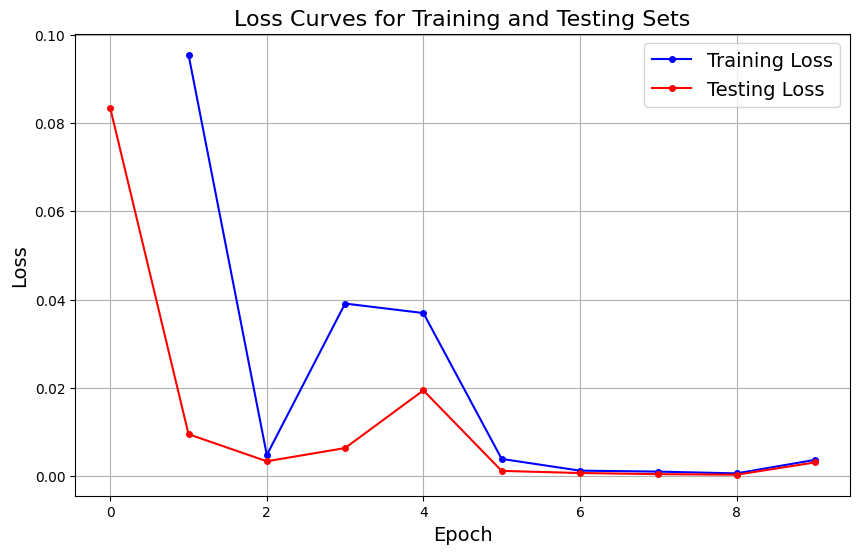

In [424]:
# 3. Plot loss curves on training and test set
plot_loss_curves(losses_train, losses_test, file_name="mlp_loss_curves_small_1")

In [425]:
# 4. Increase the number of hidden units and observe the effect on the loss curves
# create MLP
batch_size = 32
num_epochs = 10
learning_rate = 3e-2

hidden_channels = [30, 40, 50, 40, 30]
mlp = MLP(2, hidden_channels, 2)

losses_train = []
losses_test = []

# train network
losses_train, losses_test = train_network(mlp, Ntrain, Ntest, Xtrain, ytrain, Xtest, ytest, num_epochs=num_epochs, batch_size=batch_size, learning_rate=learning_rate)

100%|██████████| 250/250 [00:00<00:00, 3318.91it/s]


Epoch 1/10, Iteration 1/250, Train Loss: 0.677460253238678
Epoch 1/10, Iteration 11/250, Train Loss: 0.9904400706291199
Epoch 1/10, Iteration 21/250, Train Loss: 0.6940189003944397
Epoch 1/10, Iteration 31/250, Train Loss: 0.7290124893188477
Epoch 1/10, Iteration 41/250, Train Loss: 0.6770985722541809
Epoch 1/10, Iteration 51/250, Train Loss: 0.7092885971069336
Epoch 1/10, Iteration 61/250, Train Loss: 0.6913785338401794
Epoch 1/10, Iteration 71/250, Train Loss: 0.7903438210487366
Epoch 1/10, Iteration 81/250, Train Loss: 0.7001922130584717
Epoch 1/10, Iteration 91/250, Train Loss: 0.6958594918251038
Epoch 1/10, Iteration 101/250, Train Loss: 0.6722359657287598
Epoch 1/10, Iteration 111/250, Train Loss: 0.6885988712310791
Epoch 1/10, Iteration 121/250, Train Loss: 0.7212257385253906
Epoch 1/10, Iteration 131/250, Train Loss: 0.7040605545043945
Epoch 1/10, Iteration 141/250, Train Loss: 0.7076764702796936
Epoch 1/10, Iteration 151/250, Train Loss: 0.6872951984405518
Epoch 1/10, Iteratio

100%|██████████| 250/250 [00:00<00:00, 3419.56it/s]


Epoch 2/10, Iteration 1/250, Train Loss: 0.6933560371398926
Epoch 2/10, Iteration 11/250, Train Loss: 0.7003200650215149
Epoch 2/10, Iteration 21/250, Train Loss: 0.7077920436859131
Epoch 2/10, Iteration 31/250, Train Loss: 0.7076387405395508
Epoch 2/10, Iteration 41/250, Train Loss: 0.6983829736709595
Epoch 2/10, Iteration 51/250, Train Loss: 0.8345742225646973
Epoch 2/10, Iteration 61/250, Train Loss: 0.7373651266098022
Epoch 2/10, Iteration 71/250, Train Loss: 0.6920078992843628
Epoch 2/10, Iteration 81/250, Train Loss: 0.6817927956581116
Epoch 2/10, Iteration 91/250, Train Loss: 0.7212631702423096
Epoch 2/10, Iteration 101/250, Train Loss: 0.6853276491165161
Epoch 2/10, Iteration 111/250, Train Loss: 0.6874132752418518
Epoch 2/10, Iteration 121/250, Train Loss: 0.6780291795730591
Epoch 2/10, Iteration 131/250, Train Loss: 0.7166851758956909
Epoch 2/10, Iteration 141/250, Train Loss: 0.6923550963401794
Epoch 2/10, Iteration 151/250, Train Loss: 0.721764326095581
Epoch 2/10, Iteratio

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 3/10, Iteration 1/250, Train Loss: 0.7140527963638306
Epoch 3/10, Iteration 11/250, Train Loss: 0.6923729777336121
Epoch 3/10, Iteration 21/250, Train Loss: 0.75828617811203
Epoch 3/10, Iteration 31/250, Train Loss: 0.6755372285842896
Epoch 3/10, Iteration 41/250, Train Loss: 0.6937516927719116
Epoch 3/10, Iteration 51/250, Train Loss: 0.7277160882949829
Epoch 3/10, Iteration 61/250, Train Loss: 0.7216212749481201
Epoch 3/10, Iteration 71/250, Train Loss: 0.6946540474891663
Epoch 3/10, Iteration 81/250, Train Loss: 0.6912631988525391
Epoch 3/10, Iteration 91/250, Train Loss: 0.6654731631278992
Epoch 3/10, Iteration 101/250, Train Loss: 0.6980538964271545
Epoch 3/10, Iteration 111/250, Train Loss: 0.7514662742614746
Epoch 3/10, Iteration 121/250, Train Loss: 0.7153878808021545
Epoch 3/10, Iteration 131/250, Train Loss: 0.6912205815315247


100%|██████████| 250/250 [00:00<00:00, 3359.36it/s]


Epoch 3/10, Iteration 141/250, Train Loss: 0.6663616299629211
Epoch 3/10, Iteration 151/250, Train Loss: 0.7107117176055908
Epoch 3/10, Iteration 161/250, Train Loss: 0.6969343423843384
Epoch 3/10, Iteration 171/250, Train Loss: 0.6914393901824951
Epoch 3/10, Iteration 181/250, Train Loss: 0.6941168904304504
Epoch 3/10, Iteration 191/250, Train Loss: 0.6955277323722839
Epoch 3/10, Iteration 201/250, Train Loss: 0.7236613035202026
Epoch 3/10, Iteration 211/250, Train Loss: 0.7073625326156616
Epoch 3/10, Iteration 221/250, Train Loss: 0.702864944934845
Epoch 3/10, Iteration 231/250, Train Loss: 0.8503362536430359
Epoch 3/10, Iteration 241/250, Train Loss: 0.6941900253295898
Epoch 3/10, Iteration 1/63, Test Loss: 0.6928514838218689
Epoch 3/10, Iteration 11/63, Test Loss: 0.6702808141708374
Epoch 3/10, Iteration 21/63, Test Loss: 0.7154221534729004
Epoch 3/10, Iteration 31/63, Test Loss: 0.6702808141708374
Epoch 3/10, Iteration 41/63, Test Loss: 0.7304692268371582
Epoch 3/10, Iteration 51/

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 4/10, Iteration 1/250, Train Loss: 0.6778042912483215
Epoch 4/10, Iteration 11/250, Train Loss: 0.6948137879371643
Epoch 4/10, Iteration 21/250, Train Loss: 0.6948760747909546
Epoch 4/10, Iteration 31/250, Train Loss: 0.6840474009513855
Epoch 4/10, Iteration 41/250, Train Loss: 0.6840280890464783
Epoch 4/10, Iteration 51/250, Train Loss: 0.6982986330986023
Epoch 4/10, Iteration 61/250, Train Loss: 0.7147544026374817
Epoch 4/10, Iteration 71/250, Train Loss: 0.798093855381012
Epoch 4/10, Iteration 81/250, Train Loss: 0.7310400009155273
Epoch 4/10, Iteration 91/250, Train Loss: 0.7760639190673828
Epoch 4/10, Iteration 101/250, Train Loss: 0.7068467140197754
Epoch 4/10, Iteration 111/250, Train Loss: 0.7220397591590881
Epoch 4/10, Iteration 121/250, Train Loss: 0.7098141312599182
Epoch 4/10, Iteration 131/250, Train Loss: 0.6868644952774048


100%|██████████| 250/250 [00:00<00:00, 3452.99it/s]


Epoch 4/10, Iteration 141/250, Train Loss: 0.6939566135406494
Epoch 4/10, Iteration 151/250, Train Loss: 0.6931502819061279
Epoch 4/10, Iteration 161/250, Train Loss: 0.7009763717651367
Epoch 4/10, Iteration 171/250, Train Loss: 0.7788610458374023
Epoch 4/10, Iteration 181/250, Train Loss: 0.6633565425872803
Epoch 4/10, Iteration 191/250, Train Loss: 0.722253680229187
Epoch 4/10, Iteration 201/250, Train Loss: 0.6929383277893066
Epoch 4/10, Iteration 211/250, Train Loss: 0.7075663805007935
Epoch 4/10, Iteration 221/250, Train Loss: 0.6914159059524536
Epoch 4/10, Iteration 231/250, Train Loss: 0.6928420066833496
Epoch 4/10, Iteration 241/250, Train Loss: 0.6915513277053833
Epoch 4/10, Iteration 1/63, Test Loss: 0.7381966710090637
Epoch 4/10, Iteration 11/63, Test Loss: 0.7841466665267944
Epoch 4/10, Iteration 21/63, Test Loss: 0.6922467947006226
Epoch 4/10, Iteration 31/63, Test Loss: 0.7841466069221497
Epoch 4/10, Iteration 41/63, Test Loss: 0.6616135239601135
Epoch 4/10, Iteration 51/

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 5/10, Iteration 1/250, Train Loss: 0.7075634598731995
Epoch 5/10, Iteration 11/250, Train Loss: 0.6982864141464233
Epoch 5/10, Iteration 21/250, Train Loss: 0.6949329972267151
Epoch 5/10, Iteration 31/250, Train Loss: 0.6946445107460022
Epoch 5/10, Iteration 41/250, Train Loss: 0.6931825876235962
Epoch 5/10, Iteration 51/250, Train Loss: 0.717674195766449
Epoch 5/10, Iteration 61/250, Train Loss: 0.7068393230438232
Epoch 5/10, Iteration 71/250, Train Loss: 0.7083433270454407
Epoch 5/10, Iteration 81/250, Train Loss: 0.7790910601615906
Epoch 5/10, Iteration 91/250, Train Loss: 0.7721165418624878
Epoch 5/10, Iteration 101/250, Train Loss: 0.699724018573761
Epoch 5/10, Iteration 111/250, Train Loss: 0.6774882078170776
Epoch 5/10, Iteration 121/250, Train Loss: 0.6853540539741516
Epoch 5/10, Iteration 131/250, Train Loss: 0.6929909586906433
Epoch 5/10, Iteration 141/250, Train Loss: 0.6955387592315674


100%|██████████| 250/250 [00:00<00:00, 3441.82it/s]


Epoch 5/10, Iteration 151/250, Train Loss: 0.7449312210083008
Epoch 5/10, Iteration 161/250, Train Loss: 0.6656159162521362
Epoch 5/10, Iteration 171/250, Train Loss: 0.700147807598114
Epoch 5/10, Iteration 181/250, Train Loss: 0.716871440410614
Epoch 5/10, Iteration 191/250, Train Loss: 0.6931356191635132
Epoch 5/10, Iteration 201/250, Train Loss: 0.6656737923622131
Epoch 5/10, Iteration 211/250, Train Loss: 0.6950949430465698
Epoch 5/10, Iteration 221/250, Train Loss: 0.8004034757614136
Epoch 5/10, Iteration 231/250, Train Loss: 0.7014281153678894
Epoch 5/10, Iteration 241/250, Train Loss: 0.7226308584213257
Epoch 5/10, Iteration 1/63, Test Loss: 0.6977217197418213
Epoch 5/10, Iteration 11/63, Test Loss: 0.6644450426101685
Epoch 5/10, Iteration 21/63, Test Loss: 0.7309982776641846
Epoch 5/10, Iteration 31/63, Test Loss: 0.6644450426101685
Epoch 5/10, Iteration 41/63, Test Loss: 0.7531827688217163
Epoch 5/10, Iteration 51/63, Test Loss: 0.7309983372688293
Epoch 5/10, Iteration 61/63, 

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 6/10, Iteration 1/250, Train Loss: 0.6866295337677002
Epoch 6/10, Iteration 11/250, Train Loss: 0.6972203254699707
Epoch 6/10, Iteration 21/250, Train Loss: 0.6329958438873291
Epoch 6/10, Iteration 31/250, Train Loss: 0.7492263317108154
Epoch 6/10, Iteration 41/250, Train Loss: 0.6920784711837769
Epoch 6/10, Iteration 51/250, Train Loss: 0.6624791622161865
Epoch 6/10, Iteration 61/250, Train Loss: 0.7149511575698853
Epoch 6/10, Iteration 71/250, Train Loss: 0.6926151514053345
Epoch 6/10, Iteration 81/250, Train Loss: 0.6867531538009644
Epoch 6/10, Iteration 91/250, Train Loss: 0.6942989826202393
Epoch 6/10, Iteration 101/250, Train Loss: 0.7450402975082397
Epoch 6/10, Iteration 111/250, Train Loss: 0.7450808882713318
Epoch 6/10, Iteration 121/250, Train Loss: 0.7276953458786011
Epoch 6/10, Iteration 131/250, Train Loss: 0.6911961436271667
Epoch 6/10, Iteration 141/250, Train Loss: 0.6789930462837219


100%|██████████| 250/250 [00:00<00:00, 3397.29it/s]


Epoch 6/10, Iteration 151/250, Train Loss: 0.6879739761352539
Epoch 6/10, Iteration 161/250, Train Loss: 0.6731882095336914
Epoch 6/10, Iteration 171/250, Train Loss: 0.6794978380203247
Epoch 6/10, Iteration 181/250, Train Loss: 0.6948546767234802
Epoch 6/10, Iteration 191/250, Train Loss: 0.7191650867462158
Epoch 6/10, Iteration 201/250, Train Loss: 0.7095611691474915
Epoch 6/10, Iteration 211/250, Train Loss: 0.7076822519302368
Epoch 6/10, Iteration 221/250, Train Loss: 0.7091734409332275
Epoch 6/10, Iteration 231/250, Train Loss: 0.7126619815826416
Epoch 6/10, Iteration 241/250, Train Loss: 0.6914040446281433
Epoch 6/10, Iteration 1/63, Test Loss: 0.7571539282798767
Epoch 6/10, Iteration 11/63, Test Loss: 0.8138877153396606
Epoch 6/10, Iteration 21/63, Test Loss: 0.7004201412200928
Epoch 6/10, Iteration 31/63, Test Loss: 0.8138877749443054
Epoch 6/10, Iteration 41/63, Test Loss: 0.66259765625
Epoch 6/10, Iteration 51/63, Test Loss: 0.7004202008247375
Epoch 6/10, Iteration 61/63, Tes

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 7/10, Iteration 1/250, Train Loss: 0.794976532459259
Epoch 7/10, Iteration 11/250, Train Loss: 0.7195463180541992
Epoch 7/10, Iteration 21/250, Train Loss: 0.760970950126648
Epoch 7/10, Iteration 31/250, Train Loss: 0.8344883918762207
Epoch 7/10, Iteration 41/250, Train Loss: 0.6912219524383545
Epoch 7/10, Iteration 51/250, Train Loss: 0.6833995580673218
Epoch 7/10, Iteration 61/250, Train Loss: 0.6925250291824341
Epoch 7/10, Iteration 71/250, Train Loss: 0.6936635971069336
Epoch 7/10, Iteration 81/250, Train Loss: 0.6880031228065491
Epoch 7/10, Iteration 91/250, Train Loss: 0.7186833620071411
Epoch 7/10, Iteration 101/250, Train Loss: 0.6977507472038269
Epoch 7/10, Iteration 111/250, Train Loss: 0.7041420936584473
Epoch 7/10, Iteration 121/250, Train Loss: 0.7383214831352234
Epoch 7/10, Iteration 131/250, Train Loss: 0.6880618333816528
Epoch 7/10, Iteration 141/250, Train Loss: 0.7254794836044312


100%|██████████| 250/250 [00:00<00:00, 3031.52it/s]

Epoch 7/10, Iteration 151/250, Train Loss: 0.7255390882492065
Epoch 7/10, Iteration 161/250, Train Loss: 0.6436229944229126
Epoch 7/10, Iteration 171/250, Train Loss: 0.6944403648376465
Epoch 7/10, Iteration 181/250, Train Loss: 0.6931009888648987
Epoch 7/10, Iteration 191/250, Train Loss: 0.708905816078186
Epoch 7/10, Iteration 201/250, Train Loss: 0.6990008354187012
Epoch 7/10, Iteration 211/250, Train Loss: 0.697021484375
Epoch 7/10, Iteration 221/250, Train Loss: 0.7015194296836853
Epoch 7/10, Iteration 231/250, Train Loss: 0.6853221654891968
Epoch 7/10, Iteration 241/250, Train Loss: 0.6949518322944641
Epoch 7/10, Iteration 1/63, Test Loss: 0.7082396745681763
Epoch 7/10, Iteration 11/63, Test Loss: 0.7311593890190125
Epoch 7/10, Iteration 21/63, Test Loss: 0.6853199005126953
Epoch 7/10, Iteration 31/63, Test Loss: 0.7311594486236572
Epoch 7/10, Iteration 41/63, Test Loss: 0.6700401306152344
Epoch 7/10, Iteration 51/63, Test Loss: 0.6853199005126953


Epoch 7/10, Iteration 61/63, Test Loss: 0.7082396745681763


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 8/10, Iteration 1/250, Train Loss: 0.7311594486236572
Epoch 8/10, Iteration 11/250, Train Loss: 0.6775543093681335
Epoch 8/10, Iteration 21/250, Train Loss: 0.7828217148780823
Epoch 8/10, Iteration 31/250, Train Loss: 0.7639598250389099
Epoch 8/10, Iteration 41/250, Train Loss: 0.7335230708122253
Epoch 8/10, Iteration 51/250, Train Loss: 0.6875302195549011
Epoch 8/10, Iteration 61/250, Train Loss: 0.7317379117012024
Epoch 8/10, Iteration 71/250, Train Loss: 0.7152748703956604
Epoch 8/10, Iteration 81/250, Train Loss: 0.7006179094314575
Epoch 8/10, Iteration 91/250, Train Loss: 0.6931502223014832
Epoch 8/10, Iteration 101/250, Train Loss: 0.7646337151527405
Epoch 8/10, Iteration 111/250, Train Loss: 0.665282666683197


100%|██████████| 250/250 [00:00<00:00, 3247.21it/s]

Epoch 8/10, Iteration 121/250, Train Loss: 0.7317793369293213
Epoch 8/10, Iteration 131/250, Train Loss: 0.6772658228874207
Epoch 8/10, Iteration 141/250, Train Loss: 0.6934237480163574
Epoch 8/10, Iteration 151/250, Train Loss: 0.6853485703468323
Epoch 8/10, Iteration 161/250, Train Loss: 0.6920585632324219
Epoch 8/10, Iteration 171/250, Train Loss: 0.732693076133728
Epoch 8/10, Iteration 181/250, Train Loss: 0.7005656957626343
Epoch 8/10, Iteration 191/250, Train Loss: 0.691205620765686
Epoch 8/10, Iteration 201/250, Train Loss: 0.686773419380188
Epoch 8/10, Iteration 211/250, Train Loss: 0.7279055118560791
Epoch 8/10, Iteration 221/250, Train Loss: 0.7165631055831909
Epoch 8/10, Iteration 231/250, Train Loss: 0.756184995174408
Epoch 8/10, Iteration 241/250, Train Loss: 0.6969845294952393


Epoch 8/10, Iteration 1/63, Test Loss: 0.7184247374534607
Epoch 8/10, Iteration 11/63, Test Loss: 0.7505197525024414
Epoch 8/10, Iteration 21/63, Test Loss: 0.68632972240448
Epoch 8/10, Iteration 31/63, Test Loss: 0.7505197525024414
Epoch 8/10, Iteration 41/63, Test Loss: 0.664932906627655
Epoch 8/10, Iteration 51/63, Test Loss: 0.6863296627998352
Epoch 8/10, Iteration 61/63, Test Loss: 0.7184246778488159


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 9/10, Iteration 1/250, Train Loss: 0.664932906627655
Epoch 9/10, Iteration 11/250, Train Loss: 0.855701208114624
Epoch 9/10, Iteration 21/250, Train Loss: 0.6867602467536926
Epoch 9/10, Iteration 31/250, Train Loss: 0.691196620464325
Epoch 9/10, Iteration 41/250, Train Loss: 0.6809730529785156
Epoch 9/10, Iteration 51/250, Train Loss: 0.6881052255630493
Epoch 9/10, Iteration 61/250, Train Loss: 0.6465333104133606
Epoch 9/10, Iteration 71/250, Train Loss: 0.6925470232963562
Epoch 9/10, Iteration 81/250, Train Loss: 0.6980374455451965
Epoch 9/10, Iteration 91/250, Train Loss: 0.6617292761802673
Epoch 9/10, Iteration 101/250, Train Loss: 0.6755123138427734
Epoch 9/10, Iteration 111/250, Train Loss: 0.6929744482040405


100%|██████████| 250/250 [00:00<00:00, 3336.95it/s]

Epoch 9/10, Iteration 121/250, Train Loss: 0.6617628931999207
Epoch 9/10, Iteration 131/250, Train Loss: 0.7344737648963928
Epoch 9/10, Iteration 141/250, Train Loss: 0.6880437135696411
Epoch 9/10, Iteration 151/250, Train Loss: 0.699120283126831
Epoch 9/10, Iteration 161/250, Train Loss: 0.7300888299942017
Epoch 9/10, Iteration 171/250, Train Loss: 0.6911928653717041
Epoch 9/10, Iteration 181/250, Train Loss: 0.699826717376709
Epoch 9/10, Iteration 191/250, Train Loss: 0.6951056122779846
Epoch 9/10, Iteration 201/250, Train Loss: 0.70001220703125
Epoch 9/10, Iteration 211/250, Train Loss: 0.7048617601394653
Epoch 9/10, Iteration 221/250, Train Loss: 0.6913213133811951
Epoch 9/10, Iteration 231/250, Train Loss: 0.6926612257957458
Epoch 9/10, Iteration 241/250, Train Loss: 0.7582448720932007
Epoch 9/10, Iteration 1/63, Test Loss: 0.7066947817802429
Epoch 9/10, Iteration 11/63, Test Loss: 0.6616731882095337
Epoch 9/10, Iteration 21/63, Test Loss: 0.7517163753509521
Epoch 9/10, Iteration 

Epoch 9/10, Iteration 51/63, Test Loss: 0.7517163753509521
Epoch 9/10, Iteration 61/63, Test Loss: 0.7066947817802429


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 10/10, Iteration 1/250, Train Loss: 0.7517163753509521
Epoch 10/10, Iteration 11/250, Train Loss: 0.7183562517166138
Epoch 10/10, Iteration 21/250, Train Loss: 0.6914804577827454
Epoch 10/10, Iteration 31/250, Train Loss: 0.7016036510467529
Epoch 10/10, Iteration 41/250, Train Loss: 0.6982861757278442
Epoch 10/10, Iteration 51/250, Train Loss: 0.6866188049316406
Epoch 10/10, Iteration 61/250, Train Loss: 0.7420278787612915
Epoch 10/10, Iteration 71/250, Train Loss: 0.8784976005554199
Epoch 10/10, Iteration 81/250, Train Loss: 0.6440770030021667
Epoch 10/10, Iteration 91/250, Train Loss: 0.6804649233818054
Epoch 10/10, Iteration 101/250, Train Loss: 0.7005244493484497
Epoch 10/10, Iteration 111/250, Train Loss: 0.7676786780357361
Epoch 10/10, Iteration 121/250, Train Loss: 0.6931471824645996
Epoch 10/10, Iteration 131/250, Train Loss: 0.6925464272499084
Epoch 10/10, Iteration 141/250, Train Loss: 0.7629663944244385
Epoch 10/10, Iteration 151/250, Train Loss: 0.784052312374115
Epoc

100%|██████████| 250/250 [00:00<00:00, 3159.16it/s]

Epoch 10/10, Iteration 1/63, Test Loss: 0.6976220607757568
Epoch 10/10, Iteration 11/63, Test Loss: 0.6645113229751587
Epoch 10/10, Iteration 21/63, Test Loss: 0.7307327389717102
Epoch 10/10, Iteration 31/63, Test Loss: 0.6645113229751587
Epoch 10/10, Iteration 41/63, Test Loss: 0.752806544303894
Epoch 10/10, Iteration 51/63, Test Loss: 0.7307327389717102
Epoch 10/10, Iteration 61/63, Test Loss: 0.6976220607757568


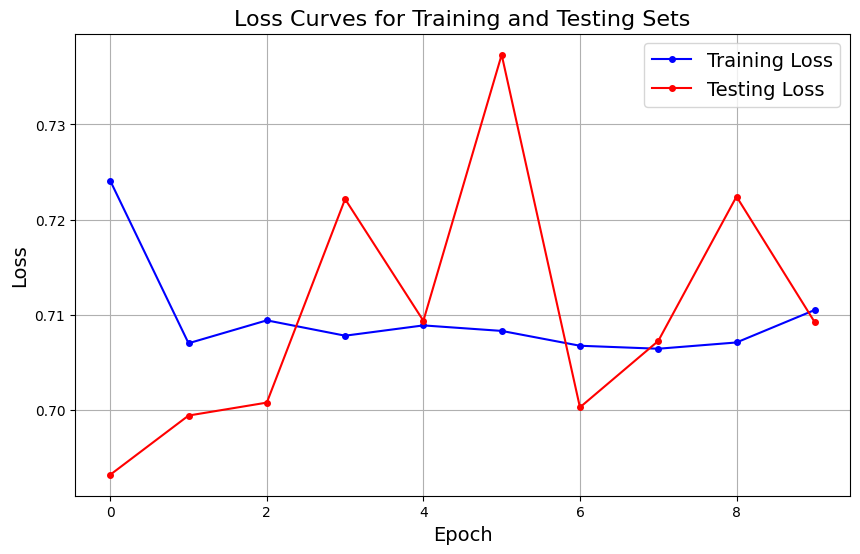

In [426]:
plot_loss_curves(losses_train, losses_test, file_name="mlp_loss_curves_large_1")

**Report what you observe on the training/test loss curves (related to a term we mentioned in the lecture)**

The toy moon dataset from Sklearn is a non-linearly separable dataset with two intertwined classes. The current MLP architecture with only two hidden layers may lack sufficient capacity to learn the complex patterns in the data, leading to high training loss and underfitting. Conversely, an excessively high capacity with multiple hidden layers may cause the model to overfit the training data, resulting in a low training loss but high test loss. Moreover, using Xavier or Glorot initialization for the weights instead of normal distribution initialization can enhance the model's learning capacity since the initialization helps to set the weights of the network to small random values that are inversely proportional to the square root of the number of input units in the previous layer. This ensures that the variance of the outputs of each layer remains consisten allowing gradients to flow through the network during backpropagation.


### Task 2: Data Preparation and Visualization

In [427]:
# prepare data for training and testing
def load_data(train=True):
    """Load train- test split for MNIST"""
    mnist = datasets.MNIST('../data',
                train=train,
                download=True)
    return mnist

In [428]:
# 1.1 Load MNIST dataset
# load train split
data_train = load_data(train=True)
data_test = load_data(train=False)

print(len(data_train))
print(len(data_test))

60000
10000


In [462]:
def plot_examples(data):
    """ Plot some examples and put their corresponding label on top as title."""
    train_set_array = np.fliplr(data.data.numpy()) # data is l-r flipped
    train_set_array_targets = data.targets.numpy()
    
    # set title for image with subplot

    fig, axs = plt.subplots(2,5, figsize=(15, 6), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()

    for i in range(10):
        axs[i].contourf(train_set_array[i], 5, cmap=plt.cm.Greys)
        axs[i].set_title(train_set_array_targets[i]) 
    
    # Set a single title for the entire figure
    fig.suptitle('MNIST Dataset', fontsize=20)

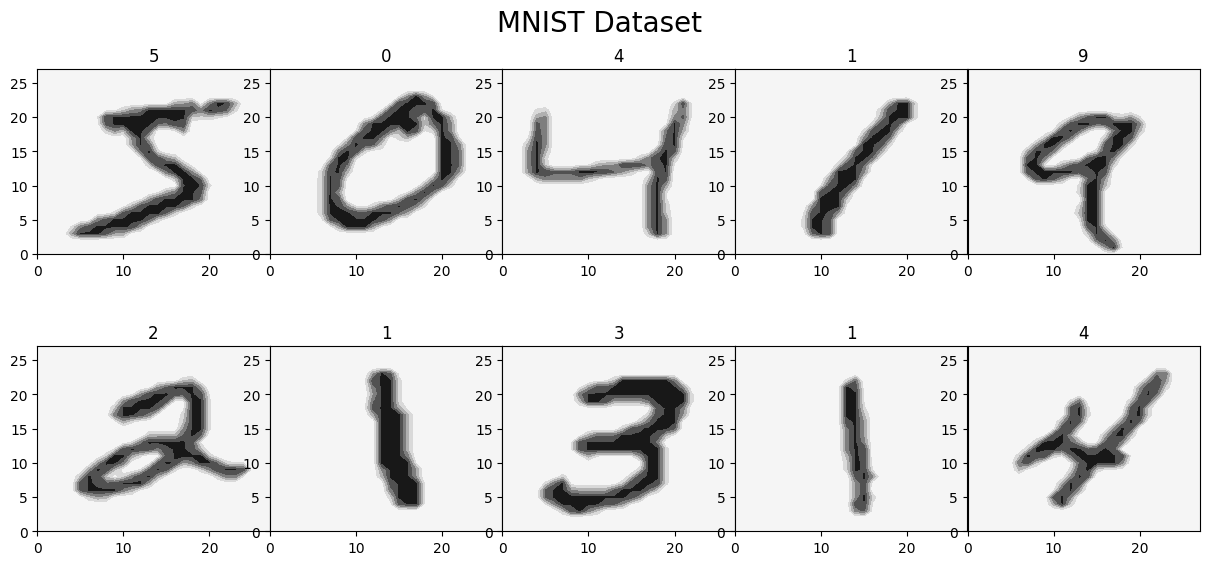

In [463]:
# 1.2 Plot some examples from the training set
plot_examples(data_train)

In [464]:
def plot_report(data: np.array) -> None:
    v_sum = np.sum(data)
    v_min = np.min(data)
    v_max = np.max(data)
    v_mean = np.mean(data)
    v_shape = data.shape
    v_dtype = data.dtype

    print("Report for train set")
    print(f"Train Sum: {v_sum}")
    print(f"Train Min: {v_min}")
    print(f"Train Max: {v_max}")
    print(f"Train Mean: {v_mean}")
    print(f"Train Shape: {v_shape}")
    print(f"Train Datatype: {v_dtype}")

In [465]:
# 1.3 Give a report about min, max, mean, and std of the training set
train_set_array = data_train.data.numpy() # data is l-r flipped
plot_report(train_set_array)

Report for train set
Train Sum: 1567298545
Train Min: 0
Train Max: 255
Train Mean: 33.318421449829934
Train Shape: (60000, 28, 28)
Train Datatype: uint8


In [466]:
def convert_mnist_to_vectors(data):
    '''Converts the ``[28, 28]`` MNIST images to vectors of size ``[28*28]``.
       It outputs mnist_vectors as a array with the shape of [N, 784], where
       N is the number of images in data.
    '''

    mnist_vectors = []
    labels = []

    for image, label in tqdm(data):
        img_array = np.asarray(image)
        img_array = np.reshape(img_array, -1) # reshape array to vector
        mnist_vectors.append(img_array)
        labels.append(label)

    # return as numpy arrays
    return np.array(mnist_vectors), labels


def norm_data(data: np.array) -> np.array:
    """Normalise vectors to be centered around 0 in a range of [-1, 1]"""
    data = data.copy()
    return 2*(data - np.min(data))/np.ptp(data) - 1

In [467]:
# 2. Convert all images into plain vectors and process them to be centered around 0
mnist_vectors, labels = convert_mnist_to_vectors(data_train)

# normalize data
mnist_vectors = norm_data(np.array(mnist_vectors))

print(mnist_vectors[:1].shape)
print(mnist_vectors.shape)

100%|██████████| 60000/60000 [00:00<00:00, 78148.69it/s]


(1, 784)
(60000, 784)


In [468]:
# Normalised [-1,1]
norm_mnist_mean = np.mean(mnist_vectors)
print(f"Train Mean: {norm_mnist_mean}")

Train Mean: -0.8714560195745021


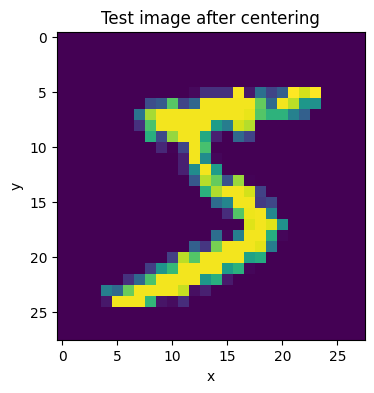

In [469]:
test_img = mnist_vectors[:1]
test_img = test_img.reshape((28, 28))
plt.imshow(test_img, interpolation='nearest')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Test image after centering")
plt.show()

In [470]:
def do_pca(data):
    '''Returns matrix [784x784] whose columns are the sorted eigenvectors.
       Eigenvectors (prinicipal components) are sorted according to their
       eigenvalues in decreasing order.
    '''

    mnist_vectors, _ = convert_mnist_to_vectors(data)
    # prepare_data(mnist_vectors)

    # compute covariance matrix of data with shape [784x784]
    cov = np.cov(mnist_vectors.T)

    # compute eigenvalues and vectors
    eigVals, eigVec = np.linalg.eig(cov)

    # sort eigenVectors by eigenValues
    sorted_index = eigVals.argsort()[::-1]
    eigVals = eigVals[sorted_index]
    sorted_eigenVectors = eigVec[:, sorted_index]
    print(type(sorted_eigenVectors), sorted_eigenVectors.shape)
    return sorted_eigenVectors.astype(np.float32).T

In [471]:
# 3. Run PCA on the MNIST dataset
eigenVectors = do_pca(data_train)

100%|██████████| 60000/60000 [00:00<00:00, 88588.63it/s]


<class 'numpy.ndarray'> (784, 784)


/var/folders/4h/v0fwv1zs4596mmdvwj516k840000gn/T/ipykernel_11444/1302327773.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  return sorted_eigenVectors.astype(np.float32).T


In [ ]:
def plot_pcs(sorted_eigenVectors, num=10):
    '''Plots the first ``num`` eigenVectors as images.'''
    fig, axs = plt.subplots(2,5, figsize=(15, 6), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()

    for i in range(num):
        img = sorted_eigenVectors[i,].reshape((28, 28))
        axs[i].contourf(img, 5, cmap=plt.cm.Oranges)
        axs[i].set_title(f"Principal Component {i}")
    
    # Set a single title for the entire figure
    fig.suptitle('Selected MNIST Dataset Eigenvectors', fontsize=20)

    # save plot to results folder
    plt.savefig(f"{RESULTS_PATH}/pca_components.png", dpi=300)

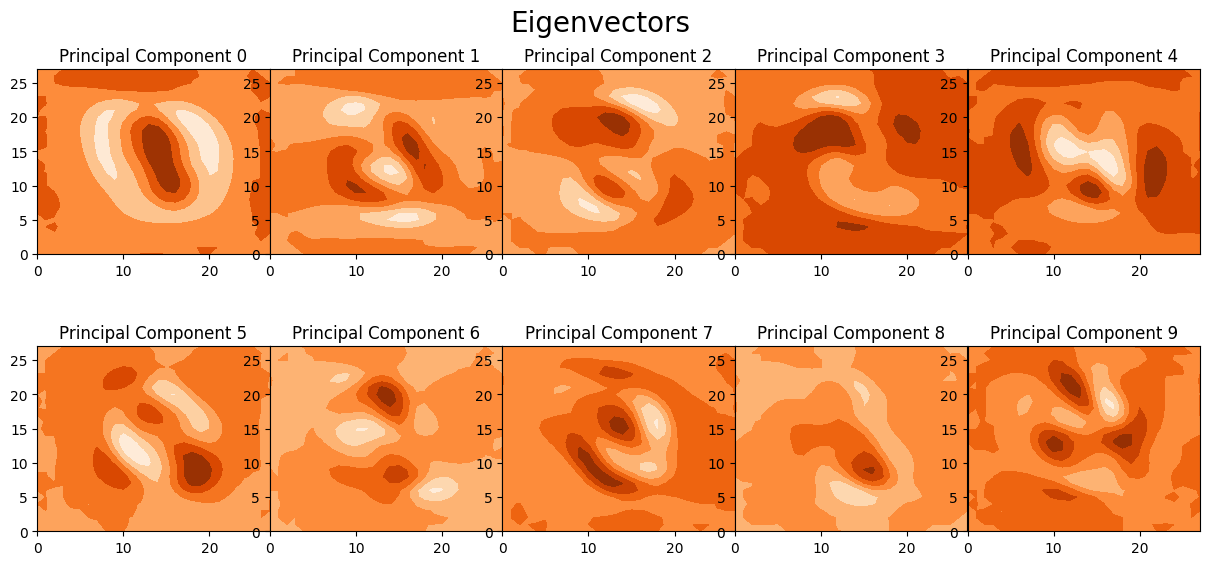

In [ ]:
# 3.2 Plot the first 10 principal components
plot_pcs(eigenVectors)

**Explain what can be observed?**

The plots visualize the ten most important principal components, which allows to explain the greatest amount of variance in the original features. Thereby, PCA identifies directions (or principal components) along which the variation in the data is maximal. Hereby, it can be observed that the spread of the values is relatively large on the y-axis with relatively less spread (variance) on the x-axis. However, since the input data follows some wave-type structure (hand-written digits) after the projection the wave shapes also show up as distortion in the plots. Thereby, a linear correlation of the principal component values is not observable. The different values for the principal components do not show any clear linear relationship between the variance of the features in the dataset. We can derive that the classes are not linear seperable. The MNIST data further does not follow a multidimensional normal (Gaussian) distribution.

**What would you expect the principal components to look like, if the problem was easy?**

If the problem was easy a linear relationship, or strong linear correlation would be observable. However, the MNIST classes are not linearly seperable which makes the problem more challenging. Additionally, a large spread, or great variance is visible.

In [ ]:
# create random colours
from random import randint

def generate_colors(amount: int) -> list:
    colors = []
    for i in range(amount):
        colors.append('#%06X' % randint(0, 0xFFFFFF))
    return colors

In [ ]:
def project_vec_2Dspace(x, y):
    """ Use of the dot product to project vectors onto each other."""
    return (np.dot(x, y) / np.linalg.norm(y)**2 ) * y # (np.dot(x, y) / np.dot(y, y)) * y

In [ ]:
def plot_projection(sorted_eigenVectors, data, path=RESULTS_PATH):
    ''' Projects ``data`` onto the first two ``sorted_eigenVectors`` and makes
        a scatterplot of the resulting points
    '''
    N = 250
    # prepare data as vectors
    mnist_vectors, labels = convert_mnist_to_vectors(data)
    
    # projection of the vetors in 2D feature space
    pc1s = np.array([project_vec_2Dspace(x, y=sorted_eigenVectors[0]) for x in mnist_vectors[:N,]])
    pc2s = np.array([project_vec_2Dspace(x, y=sorted_eigenVectors[1]) for x in mnist_vectors[:N,]])

    # get random colours
    unique_labels = np.unique(labels[:N])
    cdict = generate_colors(len(unique_labels))

    # plot all datapoints 
    fig, ax = plt.subplots()
    for g in unique_labels:
        ix = np.where(labels[:N] == g)
        x = list(pc1s[ix])
        y = list(pc2s[ix])
        ax.scatter(x, y, c=cdict[g], marker='.', label=f'class {g}')
    ax.legend()
    ax.grid()
    plt.title(f'Two Component PCA with {N} Samples')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()

    fig.savefig(f'./{path}/pca.png', dpi=fig.dpi)

(2, 784)


100%|██████████| 60000/60000 [00:00<00:00, 89659.72it/s]


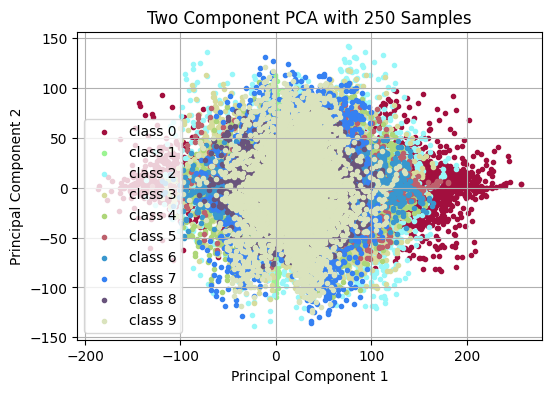

In [ ]:
# 4. Project the MNIST vectors of the train set onto the two most important principal components
# find the two main important PCs
two_main_components = eigenVectors[:2,] # start_index: end_index, 
print(two_main_components.shape)

plot_projection(two_main_components, data_train)

**Interpret the plot. What can it tell us about the MNIST dataset? Can you make a statement regarding the difficulty of MNIST digit classification problem?**

The diagram shows strong clusters and overlaps between the classes displaied, but little linear correlation within a class. Only very few classes can be separated, most are overlapping and mixed in the same PCA space. In this case, PCA may not well suited to capture non-linear relationships in a high-dimensional data set since it is itself a linear dimensionality reduction technique.

### Task 3: Defining, Training and Evaluating an MLP

In [ ]:
# 1 build 5-layer MLP
class MultilayerPerceptron(nn.Module):
    """ The multilayer perceptron does a matrix multiplication of its 
        internal weights with the inputs and adds a bias in
        each layer. After that it activates the resulting vector.
        This can be done using the `Linear` layer. 
    """
    
    def __init__(self, size_hidden=100, size_out=10):
        """ Each hidden layer has 100 hidden units (output feature dimension).
            All hidden layers use ReLU activations.
        """
        super().__init__()
        # number of hidden nodes in each layer (100)
        # linear layer (784 -> hidden_1)
        self.fc1 = torch.nn.Linear(28*28, size_hidden) # Your Code here
        # linear layer (n_hidden -> n_hidden)
        self.fc2 = torch.nn.Linear(100, size_hidden)
        # linear layer (n_hidden -> n_hidden)
        self.fc3 = torch.nn.Linear(100, size_hidden)
        # linear layer (n_hidden -> n_hidden)
        self.fc4 = torch.nn.Linear(100, size_hidden)
        # linear layer (n_hidden -> size_out)
        self.out_layer = torch.nn.Linear(100, size_out)
        
        self.relu = torch.nn.ReLU()
        
    def forward(self, x):
        # flatten the image, 
        # the -1 is a wildcard
        x = x.view(-1, 28*28)
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.relu(out)
        out = self.fc4(out)
        out = self.relu(out)
        # flatten the output signal
        out = out.view(out.size(0), -1)
        out = self.out_layer(out)
        
        # no softmax as multi-class 
        # classification not probabilities

        return out

In [ ]:
class MnistVectors(torch.utils.data.Dataset):
    ''' A Pytorch Dataset, which does the same 
        data preparation as was done in the PCA exercise.
    '''

    def __init__(self, split='train'):
        super().__init__()
        # torch dataset with casting operation
        mnist_train = datasets.MNIST('../data',
                               train=split=='train',
                               download=True)

        self.mnist_vectors, self.labels = convert_mnist_to_vectors(mnist_train)

            
    def __getitem__(self, idx):
        ''' Implements the ``[idx]`` method. Here we convert the numpy data to
            torch tensors.
        '''
        mvec = torch.tensor(self.mnist_vectors[idx]).float()
        label = torch.tensor(self.labels[idx]).long()

        return mvec, label
    
    def __len__(self):
        return len(self.labels)

In [ ]:
# 3. Implement a function, which can report the accuracy of a batch of predictions in percent.

def batch_accuracy(prediction, label):
    """Uses labels to calculate the batch accuracy"""
    N = prediction.size(0)
    acc = prediction.eq(label.view_as(label)).sum().item()
    return (acc / N) * 100


def class_label(prediction):
    """ Transforms the output of the MultilayerPerceptron 
        into a scalar class label 
    """
    return prediction.argmax(dim=1)

def normalize_output(img):
    """ Normalizes the image to be in the range [0, 1]
        and converts it to a numpy array.
    """
    img = img - img.min()
    img = img / img.max()
    return img

In [ ]:
# Visualize feature maps
activation = {}

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [ ]:
# Visualize feature maps
act_fc1, act_fc2, act_fc3, act_fc4 = [], [], [], []
labels = []

In [ ]:
def get_feature_maps(model, dataset=None, use_gpu=False):

    # define hook
    activation = {}

    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook

    # register hooks
    model.fc1.register_forward_hook(get_activation('fc1'))
    model.fc2.register_forward_hook(get_activation('fc2'))
    model.fc3.register_forward_hook(get_activation('fc3'))
    model.fc4.register_forward_hook(get_activation('fc4'))

    if not dataset:
        dataset = datasets.MNIST(
        root='../data',
        train=False,
        transform=transforms.ToTensor()
    )

    count = 0
    with torch.no_grad():
        for data_sample, label in dataset:
            
            data_sample = np.reshape(data_sample, -1)
            data_sample.unsqueeze_(0)

            if use_gpu:
                data_sample = data_sample.cuda()
                label = label.cuda()
                
            pred = model(data_sample)

            act1 = activation['fc1'].squeeze()
            act2 = activation['fc2'].squeeze()
            act3 = activation['fc3'].squeeze()
            act4 = activation['fc4'].squeeze()

            # collect activated feature maps
            act_fc1.append(act1.detach().cpu().numpy())
            act_fc2.append(act2.detach().cpu().numpy())
            act_fc3.append(act3.detach().cpu().numpy())
            act_fc4.append(act4.detach().cpu().numpy())

            # collect all labels
            labels.append(label)
            count += 1

        print(f" Done after {count} steps!")

In [ ]:
def validate(test, model, criterion, use_gpu=False):
        test_accuracies = []
        test_losses = []
        
        model.eval()
        
        with torch.no_grad():
            for idx, [test_examples, test_labels] in enumerate(tqdm(test, desc='Test')):
                if use_gpu:
                    test_examples = test_examples.cuda()
                    test_labels = test_labels.cuda()
                
                test_prediction = model(test_examples)
                
                # evaluation
                test_loss = criterion(test_prediction, test_labels).data.item()
                test_acc = batch_accuracy(class_label(test_prediction), test_labels)

                if (idx % 10) == 0:
                    print('Test Batch Accuracy: {}%, Test Loss: {}'.format(test_acc, test_loss))
                
                test_accuracies.append(test_acc) # per batch
                test_losses.append(test_loss)

        # Use the batch_accuracy function, also print the mean accuracy
        # over the whole test split of the data.

        print('Mean Validation Accuracy: {}%'.format(np.mean(test_accuracies)))
        print('Mean Validation Loss: {}%'.format(np.mean(test_losses)))

        plt.plot(test_accuracies)

In [ ]:
def train(use_gpu=False): # if torch.cuda.is_available(), use gpu to speed up training
    
    # Here we instantiate our model. The weights of the model are automatically
    # initialized by pytorch
    model = MultilayerPerceptron()
    
    TrainData = MnistVectors()
    TestData = MnistVectors('test')

    # Dataloaders allow us to load the data in batches. This allows us a better
    # estimate of the parameter updates when doing backprop.
    # We need two Dataloaders so that we can train on the train data split
    # and evaluate on the test datasplit.
    
    Dl = DataLoader(TrainData, batch_size=16, shuffle=True)
    testDl = DataLoader(TestData, batch_size=16, shuffle=False)
    
    # Use the Adam optimizer with learning rate 1e-4 and otherwise default
    # values
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    # Use the Cross Entropy loss from pytorch. Make sure your MultilayerPerceptron does
    # not use any activation function on the output layer! (Do you know why?) 
    criterion = nn.CrossEntropyLoss()
    
    if use_gpu:
        model.cuda()
        criterion.cuda()
    
    for epoch in tqdm(range(5), desc='Epoch'):
        for step, [example, label] in enumerate(tqdm(Dl, desc='Batch')):
            if use_gpu:
                example = example.cuda()
                label = label.cuda()
            
            # The optimizer knows about all model parameters. These in turn
            # store their own gradients. When calling loss.backward() the newly
            # computed gradients are added on top of the existing ones. Thus
            # at before calculating new gradients we need to clear the old ones
            # using ther zero_grad() method.
            
            optimizer.zero_grad()
            
            prediction = model(example)
            loss = criterion(prediction, label)
            
            # Here pytorch applies backpropagation for us completely
            loss.backward()

            # The step method now adds the gradients onto the model parameters
            # as specified by the optimizer and the learning rate.
            optimizer.step()
            
            # To keep track of what is happening print some outputs from time to time.
            if (step % 375) == 0:
                acc = batch_accuracy(class_label(prediction), label)
                tqdm.write('Batch Accuracy: {}%, Loss: {}'.format(acc, loss))
        
        # checkpoints to reuse model weights
        torch.save(model.state_dict(), 'perceptron_{}.ckpt'.format(step))

    # Now validate on the whole test set
    validate(testDl, model, criterion, use_gpu)

    # If you need to load the checkpoint instanciate your model and the
    # load the state dict from a checkpoint:
    # model = MultilayerPerceptron()
    # model.load_state_dict(torch.load(perceptron_3750.ckpt))
    # Make sure to use the latest checkpoint by entering the right number.

    ######################################
    ######      Code for task 4     ######
    ######################################

    get_feature_maps(model, use_gpu=use_gpu)

In [509]:
train(use_gpu=True if torch.cuda.is_available() else False)

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]   

Batch Accuracy: 12.5%, Loss: 3.0552704334259033



Epoch:   0%|          | 0/5 [00:00<?, ?it/s]              

Batch Accuracy: 93.75%, Loss: 0.19171518087387085



Epoch:   0%|          | 0/5 [00:00<?, ?it/s]              

Batch Accuracy: 87.5%, Loss: 0.2244502753019333



Epoch:   0%|          | 0/5 [00:01<?, ?it/s]               

Batch Accuracy: 100.0%, Loss: 0.03874153271317482



Epoch:   0%|          | 0/5 [00:01<?, ?it/s]               

Batch Accuracy: 93.75%, Loss: 0.24925309419631958



Epoch:   0%|          | 0/5 [00:02<?, ?it/s]               

Batch Accuracy: 87.5%, Loss: 0.2978106737136841



Epoch:   0%|          | 0/5 [00:02<?, ?it/s]               

Batch Accuracy: 100.0%, Loss: 0.04339718446135521



Epoch:   0%|          | 0/5 [00:03<?, ?it/s]               

Batch Accuracy: 87.5%, Loss: 0.33689263463020325



Epoch:   0%|          | 0/5 [00:03<?, ?it/s]               

Batch Accuracy: 100.0%, Loss: 0.021602822467684746



Epoch:   0%|          | 0/5 [00:04<?, ?it/s]               

Batch Accuracy: 93.75%, Loss: 0.1099139004945755


Epoch:  20%|██        | 1/5 [00:04<00:19,  4.78s/it]

Batch Accuracy: 87.5%, Loss: 0.18284687399864197



Epoch:  20%|██        | 1/5 [00:05<00:19,  4.78s/it]      

Batch Accuracy: 87.5%, Loss: 0.18221403658390045



Epoch:  20%|██        | 1/5 [00:06<00:19,  4.78s/it]      

Batch Accuracy: 100.0%, Loss: 0.02895868383347988



Epoch:  20%|██        | 1/5 [00:06<00:19,  4.78s/it]       

Batch Accuracy: 93.75%, Loss: 0.16330744326114655



Epoch:  20%|██        | 1/5 [00:07<00:19,  4.78s/it]       

Batch Accuracy: 87.5%, Loss: 0.3731202483177185



Epoch:  20%|██        | 1/5 [00:07<00:19,  4.78s/it]       

Batch Accuracy: 93.75%, Loss: 0.3326825797557831



Epoch:  20%|██        | 1/5 [00:08<00:19,  4.78s/it]       

Batch Accuracy: 93.75%, Loss: 0.06840353459119797



Epoch:  20%|██        | 1/5 [00:08<00:19,  4.78s/it]       

Batch Accuracy: 100.0%, Loss: 0.007415989879518747



Epoch:  20%|██        | 1/5 [00:09<00:19,  4.78s/it]       

Batch Accuracy: 93.75%, Loss: 0.2593940496444702



Epoch:  20%|██        | 1/5 [00:10<00:19,  4.78s/it]       

Batch Accuracy: 100.0%, Loss: 0.056532520800828934


Epoch:  40%|████      | 2/5 [00:10<00:16,  5.42s/it]

Batch Accuracy: 100.0%, Loss: 0.047877732664346695



Epoch:  40%|████      | 2/5 [00:11<00:16,  5.42s/it]      

Batch Accuracy: 93.75%, Loss: 0.06384523957967758



Epoch:  40%|████      | 2/5 [00:12<00:16,  5.42s/it]      

Batch Accuracy: 100.0%, Loss: 0.014743420295417309



Epoch:  40%|████      | 2/5 [00:12<00:16,  5.42s/it]       

Batch Accuracy: 100.0%, Loss: 0.0021961338352411985



Epoch:  40%|████      | 2/5 [00:13<00:16,  5.42s/it]       

Batch Accuracy: 100.0%, Loss: 0.02547832578420639



Epoch:  40%|████      | 2/5 [00:13<00:16,  5.42s/it]       

Batch Accuracy: 93.75%, Loss: 0.12677745521068573



Epoch:  40%|████      | 2/5 [00:14<00:16,  5.42s/it]       

Batch Accuracy: 100.0%, Loss: 0.009354074485599995



Epoch:  40%|████      | 2/5 [00:14<00:16,  5.42s/it]       

Batch Accuracy: 100.0%, Loss: 0.023930633440613747



Epoch:  40%|████      | 2/5 [00:15<00:16,  5.42s/it]       

Batch Accuracy: 93.75%, Loss: 0.27901095151901245



Epoch:  40%|████      | 2/5 [00:15<00:16,  5.42s/it]       

Batch Accuracy: 100.0%, Loss: 0.041883643716573715


Epoch:  60%|██████    | 3/5 [00:16<00:11,  5.53s/it]

Batch Accuracy: 100.0%, Loss: 0.0024087154306471348



Epoch:  60%|██████    | 3/5 [00:16<00:11,  5.53s/it]      

Batch Accuracy: 100.0%, Loss: 0.020591529086232185



Epoch:  60%|██████    | 3/5 [00:17<00:11,  5.53s/it]      

Batch Accuracy: 100.0%, Loss: 0.007210385520011187



Epoch:  60%|██████    | 3/5 [00:17<00:11,  5.53s/it]       

Batch Accuracy: 100.0%, Loss: 0.017204808071255684



Epoch:  60%|██████    | 3/5 [00:18<00:11,  5.53s/it]       

Batch Accuracy: 100.0%, Loss: 0.019439280033111572



Epoch:  60%|██████    | 3/5 [00:18<00:11,  5.53s/it]       

Batch Accuracy: 93.75%, Loss: 0.06410225480794907



Epoch:  60%|██████    | 3/5 [00:19<00:11,  5.53s/it]       

Batch Accuracy: 93.75%, Loss: 0.14713667333126068


#### Task 4: Visualizing MLP Features

In [ ]:
# 1. MNIST images of the test split, or if you have limited computational resource for a subset of at least 1000 image
print(np.asarray(act_fc1).shape)

(10000, 100)


In [ ]:
# 2. find PCA of vectors and project feature maps onto the first two principal components
def convert_act_to_vectors(data):
    '''Converts the activated feature maps to vectors of size ``[n*m]``.
       It outputs mnist_vectors as a array with the shape of [N, n*m], where
       N is the number of maps in data.
    '''

    act_vectors = []

    for act in tqdm(data):
        act_array = np.asarray(act)
        act_array = np.reshape(act_array, -1) # reshape array to vector
        act_vectors.append(act_array)
    
    # return as numpy arrays
    return norm_data(np.array(act_vectors))

In [ ]:
def do_pca_actm(data):
    '''Returns matrix [nxm] whose columns are the sorted eigenvectors.
       Eigenvectors (prinicipal components) are sorted according to their
       eigenvalues in decreasing order.
       >>> PCA compresses the input data into its representation.
    '''

    actm_vectors = convert_act_to_vectors(data)
    # prepare_data(actm_vectors)

    # compute covariance matrix of data
    cov = np.cov(actm_vectors.T)

    # compute eigenvalues and vectors
    eigVals, eigVec = np.linalg.eig(cov)

    # sort eigenVectors by eigenValues descending
    sorted_index = eigVals.argsort()[::-1]
    eigVals = eigVals[sorted_index]
    sorted_eigenVectors = eigVec[:, sorted_index]
    print(type(sorted_eigenVectors), sorted_eigenVectors.shape)
    
    return sorted_eigenVectors.astype(np.float64).T

In [ ]:
pca_act_fc1 = do_pca_actm(act_fc1)
pca_act_fc2 = do_pca_actm(act_fc2)
pca_act_fc3 = do_pca_actm(act_fc3)
pca_act_fc4 = do_pca_actm(act_fc4)

print(pca_act_fc1.shape)
print(pca_act_fc2.shape)
print(pca_act_fc3.shape)
print(pca_act_fc4.shape)

100%|██████████| 10000/10000 [00:00<00:00, 1349692.37it/s]


<class 'numpy.ndarray'> (100, 100)


100%|██████████| 10000/10000 [00:00<00:00, 356291.91it/s]


<class 'numpy.ndarray'> (100, 100)


100%|██████████| 10000/10000 [00:00<00:00, 706468.59it/s]


<class 'numpy.ndarray'> (100, 100)


100%|██████████| 10000/10000 [00:00<00:00, 568642.08it/s]

<class 'numpy.ndarray'> (100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)


(2, 100)


10000it [00:00, 593816.49it/s]


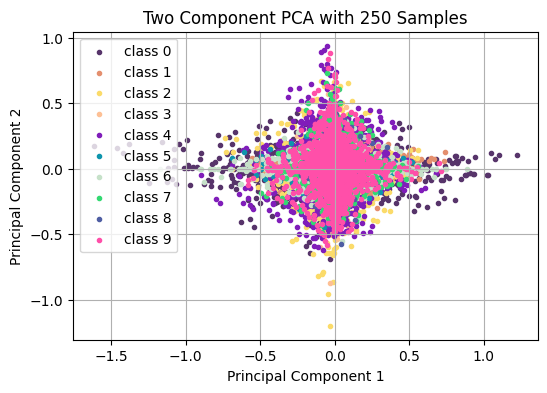

In [ ]:
# 3. Make a scatter plot of the projected feature maps onto the first two principal components
# find the two main important PCs
two_main_components = pca_act_fc1[:2,] # start_index: end_index, 
print(two_main_components.shape)

plot_projection(two_main_components, zip(act_fc1, labels))

(2, 100)


10000it [00:00, 1242572.66it/s]


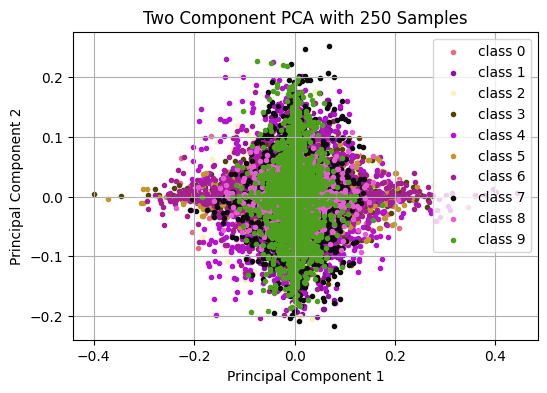

In [ ]:
# find the two main important PCs
two_main_components = pca_act_fc2[:2,] # start_index: end_index, 
print(two_main_components.shape)

plot_projection(two_main_components, zip(act_fc2, labels))

(2, 100)


10000it [00:00, 1339605.24it/s]


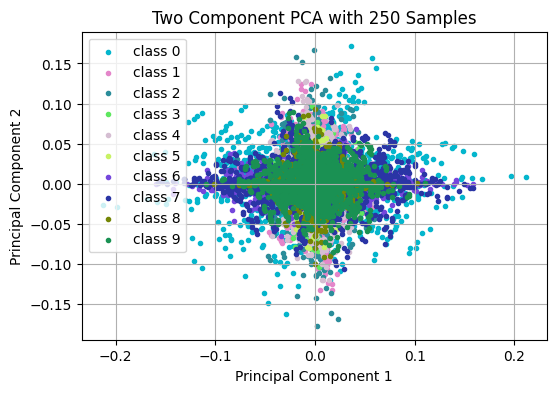

In [ ]:
# find the two main important PCs
two_main_components = pca_act_fc3[:2,] # start_index: end_index, 
print(two_main_components.shape)

plot_projection(two_main_components, zip(act_fc3, labels))

(2, 100)


10000it [00:00, 1341404.63it/s]


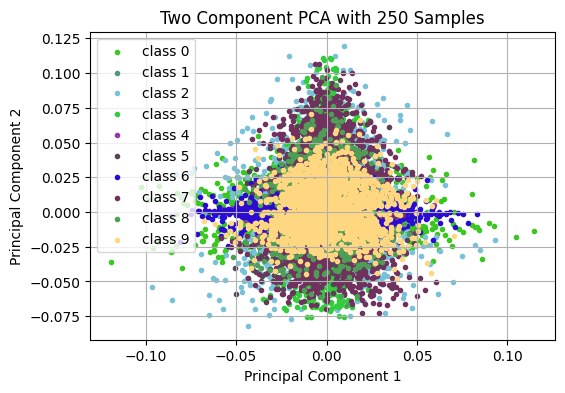

In [ ]:
# find the two main important PCs
two_main_components = pca_act_fc4[:2,] # start_index: end_index, 
print(two_main_components.shape)

plot_projection(two_main_components, zip(act_fc4, labels))

**Compare the plots to the scatter plot from task 2. What has changed, what is similar?**

The PCA plots show a progressive scattering of salient features along the x- and y-axis through the model layers, indicating a more linear correlation within classes. However, the overlap of features in classes persists, and the variance within classes remains high. The scatter plot from task 2 also showed high variance and overlap, but the PCA plots reveal a more structured distribution of features, particularly in later layers. Thereby, the MNIST digit classification challenge can be understood as difficult due to the high variance within classes and the lack of linear separability between them.

**Do you believe that the MLP is a suitable method for MNIST digit classification? Provide an explanation.**

MLPs are relatively simple and suitable for structured data, making them a good baseline model for MNIST digit classification. However, CNNs are better suited for processing large image datasets as they can capture spatial relationships between pixels and develop an internal representation of the training dataset. CNNs also use weight sharing, making them more parameter-efficient than MLPs. Therefore, while an MLP can be used as a starting point, a CNN is likely to achieve better performance on the MNIST dataset.
